In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bisect
from statannotations.Annotator import Annotator

## Setting up the Data 

In [2]:
#define chromosomes
chromosomes = ["chr{}".format(i) for i in range(1, 22)] + ["chrX", "chrY"]

In [3]:
TAD_path = "../data/clusterTAD/"
figure_path = "../output/figures/"

In [4]:
#analysis-dependent information
#initialize lists with sample names 
naive_samples = ["10k_Naive_iPSC", "25k_Naive_iPSC", "500k_Naive_iPSC"]
pgclc_samples = ["CD38P_3", "CD38P_2", "CD38P_1"]

#titles for graphics
titles1 = ["Naive 10k", "Naive 25k", "Naive 500k",
           "hPGCLC 12k", "hPGCLC 24k", "hPGCLC 25k"]
samples1 = naive_samples + pgclc_samples

In [5]:
# define dictionary for sample dataframes
def sample_compare(samples_all):    
    sample_dfs = {}
    for sample in samples_all:
        for chr in chromosomes:
            TADfile = "BestTAD_{}_40000_iced_{}.txt".format(sample, chr)
            # create dataframe for current sample
            df = pd.read_table("{}{}/{}".format(TAD_path, sample, TADfile))
            # define dict key
            key = "TAD_{}_{}".format(sample, chr)
            # populate dictionary 
            sample_dfs[key] = df
            # add column with TAD sizes
            df['distance'] = df['to.cord'] - df['from.cord']
    
    return sample_dfs

In [6]:
#generate dataframes
sample_dfs = sample_compare(samples1)

## Prepare Data for Boxplots

In [7]:
#split df in 2 groups for better visualization
half1 = pd.DataFrame(columns=['TAD_size', 'replicate', 'chromosome'])
half2 = pd.DataFrame(columns=['TAD_size', 'replicate', 'chromosome'])

for sample in naive_samples:
    for chrom in chromosomes[0:11]:
        
        current_df = sample_dfs['TAD_'+sample+'_'+chrom]
        current_df_len = current_df.index.shape[0] 
        new_df = pd.DataFrame({'TAD_size': current_df['distance'], 
                               'replicate': [sample]*current_df_len,
                               'chromosome': [chrom]*current_df_len})
        half1 = half1.append(new_df)

    for chrom in chromosomes[11:23]:
        
        current_df = sample_dfs['TAD_'+sample+'_'+chrom]
        current_df_len = current_df.index.shape[0] 
        new_df = pd.DataFrame({'TAD_size': current_df['distance'], 
                               'replicate': [sample]*current_df_len,
                               'chromosome': [chrom]*current_df_len})
        half2 = half2.append(new_df)

## Boxplots

In [8]:
sns.set(rc={'figure.figsize':(15,7)})
sns.set_style("white")

In [10]:
#format dfs so that TADs can be grouped by cell types
#in other words, replicates are clustered together
half1_copy = half1.copy()
half2_copy = half2.copy()

half1_copy = half1_copy.replace(['10k_Naive_iPSC', 
                                 '25k_Naive_iPSC', 
                                 '500k_Naive_iPSC'], 'Naive iPSCs')

half2_copy = half2_copy.replace(['10k_Naive_iPSC', 
                                 '25k_Naive_iPSC', 
                                 '500k_Naive_iPSC'], 'Naive iPSCs')

for sample in pgclc_samples:
    for chrom in chromosomes[0:11]:
        
        current_df = sample_dfs['TAD_'+sample+'_'+chrom]
        current_df_len = current_df.index.shape[0] 
        new_df = pd.DataFrame({'TAD_size': current_df['distance'], 
                               'replicate': ['PGCLCs']*current_df_len,
                               'chromosome': [chrom]*current_df_len})
        half1_copy = half1_copy.append(new_df)

    for chrom in chromosomes[11:23]:
        
        current_df = sample_dfs['TAD_'+sample+'_'+chrom]
        current_df_len = current_df.index.shape[0] 
        new_df = pd.DataFrame({'TAD_size': current_df['distance'], 
                               'replicate': ['PGCLCs']*current_df_len,
                               'chromosome': [chrom]*current_df_len})
        half2_copy = half2_copy.append(new_df)
        
half1_copy = half1_copy.rename(columns = {'replicate': 'sample'}, inplace = False)
half2_copy = half2_copy.rename(columns = {'replicate': 'sample'}, inplace = False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

chr10_Naive iPSCs vs. chr10_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:4.122e-01 U_stat=2.200e+04
chr11_Naive iPSCs vs. chr11_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.842e-01 U_stat=2.449e+04
chr9_Naive iPSCs vs. chr9_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.916e-01 U_stat=5.094e+03
chr2_Naive iPSCs vs. chr2_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.136e-02 U_stat=4.541e+04
chr1_Naive iPSCs vs. chr1_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:9.994e-01 U_stat=3.916e+04
chr3_Naive iPSCs vs. chr3_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.150e-02 U_stat=2.916e+04
chr4_Naive iPSCs vs. chr4_PGCLCs: Mann-Whitney-Wilcoxon test two-sided, P_val:2.394e-02 U_stat=2.771e+04
chr5_Naive iPSCs vs. chr5_PGCLCs: Mann-Whitney-Wilcoxon test two-side

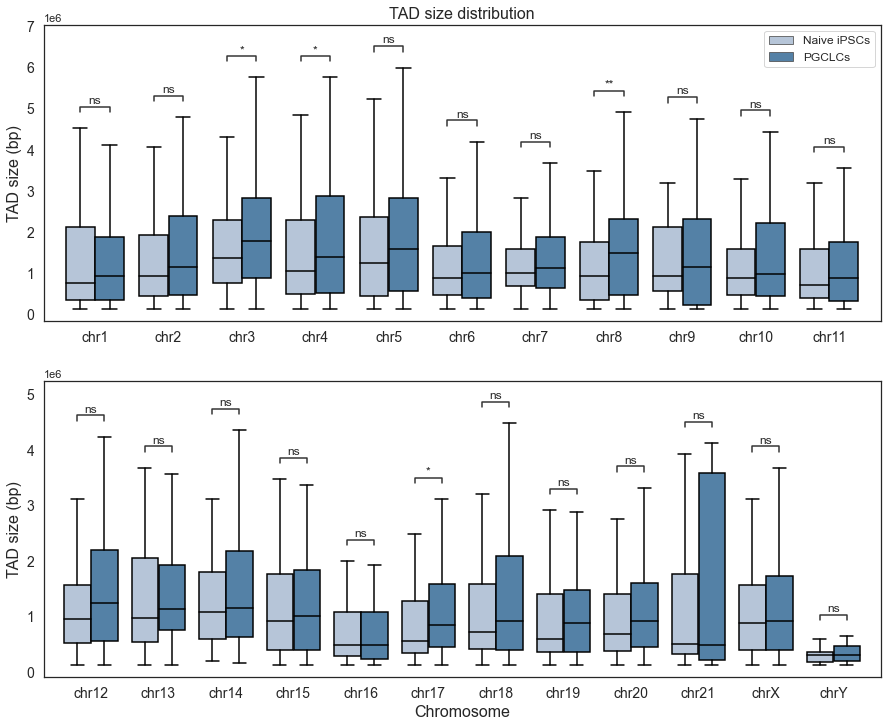

In [11]:
fig, axn = plt.subplots(2, 1, figsize=(15,12))

hue_plot_params = {'x': 'chromosome', 'y': 'TAD_size',
                   "hue": "sample", 'palette': {'Naive iPSCs': 'lightsteelblue', 
                                                'PGCLCs': 'steelblue'}}

boxprops = {'boxprops': {'edgecolor': 'black'},
            'medianprops': {'color': 'black'},
            'whiskerprops': {'color': 'black'},
            'capprops': {'color': 'black'}}

for ax_, df_ in zip(axn, [half1_copy, half2_copy]):

    chr_ = df_['chromosome'].unique()
    pairs = []
    for chrom in chr_:
        pairs.append([(chrom, "Naive iPSCs"), (chrom, "PGCLCs")])

    hue_plot_params['data'] = df_
    sns.boxplot(ax=ax_, showfliers=False, **{**hue_plot_params, **boxprops})

    #add annotations
    annotator = Annotator(ax_, pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney").apply_and_annotate()

    #axis and legend formatting 
    if ax_ == axn[1]:
        ax_.legend_.remove()
        ax_.set_xlabel('Chromosome', fontsize=16)
    
    if ax_ == axn[0]:
        ax_.legend(fontsize=12)
        ax_.set_title('TAD size distribution', fontsize=16)
        ax_.set_xlabel('')    
    
    ax_.tick_params(axis='both', which='major', labelsize=14)
    ax_.set_ylabel('TAD size (bp)', fontsize=16)
    
# plt.savefig('{}TAD_size_distribution.png'.format(figure_path), 
#             bbox_inches='tight', dpi=300)
plt.show()

### Using predetermined intervals to cluster TADs

In [12]:
def cluster_assign(sample_df, interval_lst):
    
    cluster_list = []
    intervals = []

    for TAD in sample_df['distance']:
        ind = bisect.bisect(interval_lst, int(TAD))
        k = ind-1
        if k < 0:
            k=0
        cluster_list.append(k)
        if ind < len(interval_lst):
            intervals.append((interval_lst[ind-1], interval_lst[ind]))
        else:
            #largest TAD size found in all sample
            intervals.append((interval_lst[ind-1], 30000000)) 

    sample_df['clusters'] = cluster_list
    sample_df['intervals'] = intervals
    
    return sample_df  

def cluster_assign_pt2(sample_lst, sample_dfs, interval_lst):
    
    for control, test in zip(sample_lst[0:3], sample_lst[3:6]):
        for chrom in chromosomes:
            
            control_df = sample_dfs['TAD_'+control+'_'+chrom]
            test_df = sample_dfs['TAD_'+test+'_'+chrom]

            #now, cluster TADs in control samples
            control_df = cluster_assign(control_df, interval_lst)

            #now, cluster TADs in test samples
            test_df = cluster_assign(test_df, interval_lst)

In [13]:
predetermined_intervals = [0, 200000, 1000000, 1500000, 2000000, 2500000]
cluster_assign_pt2(samples1, sample_dfs, predetermined_intervals)

### Count cluster frequency

In [14]:
def TAD_freq_count(sample_dfs, sample_name, text, chrom):

    #load sample
    sample = sample_dfs['TAD_'+sample_name+'_'+chrom]
    sample_TAD_ct = sample.groupby('clusters')['from.id'].nunique()
    sample_TAD_ct = pd.DataFrame(sample_TAD_ct)
    sample_TAD_ct.rename(columns={'from.id': 'freq.'+text}, inplace=True)
    sample_TAD_ct = sample_TAD_ct.reset_index()

    #Group by 'clusters' column
    grouped_sample = sample.groupby("clusters")

    #Compute means
    mean_sample = grouped_sample['distance'].mean()

    #Reset indices to match format
    mean_sample = mean_sample.reset_index()
    mean_sample = pd.DataFrame(mean_sample)
    mean_sample = mean_sample.round()
    mean_sample.rename(columns={'distance': 'avg.dist.'+text}, inplace=True)

    #Put everything in a single df
    sample_stats = pd.concat([sample_TAD_ct, mean_sample], axis=1)
    
    return sample_stats

In [15]:
#count cluster frequency
def TAD_freq_concat(sample_dfs, control, text, chrom):
        
    #count freq of each cluster 
    control_stats = TAD_freq_count(sample_dfs, control, 'naive', chrom)
    test_stats = TAD_freq_count(sample_dfs, text, 'pgclc', chrom)
    
    #combine control and test stats into single df
    concat_ct = pd.concat([control_stats, test_stats], axis=1)
    concat_ct = concat_ct.fillna(0)
    concat_ct = concat_ct.loc[:,~concat_ct.columns.duplicated()]
    df_len = concat_ct.index.shape[0] 
    
    #map interval names to cluster numbers
    interval_names = ['0-200Kb', '200Kb-1Mb', '1-1.5Mb', '1.5-2Mb', '2-2.5Mb', '>2.5Mb']
    interval_names = dict(zip(range(df_len), interval_names))
    concat_ct['intervals'] = concat_ct['clusters'].map(interval_names)
    
    return concat_ct

In [16]:
sample_pair_dict = {}

for control, test, pair in zip(samples1[0:3], samples1[3:6], 
                               ['pair1', 'pair2', 'pair3']):
    
    #Initialize dataframe to store results
    sample_pair_df = pd.DataFrame(columns = ['pair', 'clusters', 
                                             'freq.naive', 'avg.dist.naive',
                                             'freq.pgclc', 'avg.dist.pgclc', 
                                             'intervals', 'chromosome'])

    for chrom in chromosomes:
    
        #print(chrom + ': '+ control + ' and ' + test)
        concat_ct_ = TAD_freq_concat(sample_dfs, control, test, chrom)
        concat_ct_['chromosome'] = [chrom]*concat_ct_.shape[0]
        sample_pair_df = sample_pair_df.append(concat_ct_)
    
    #add pair name
    sample_pair_df['pair'] = [pair]*sample_pair_df.shape[0]
    sample_pair_dict[pair] = sample_pair_df

In [17]:
#concat all pairs
all_pairs = pd.concat(sample_pair_dict.values(), ignore_index=True)

# Reshape the DataFrame for Seaborn
df_melted = all_pairs.melt(id_vars=['clusters', 'chromosome', 'pair'], 
                            value_vars=['freq.naive', 'freq.pgclc'], 
                            var_name='sample', 
                            value_name='frequency')
df_melted

,clusters,chromosome,pair,sample,frequency
0,0,chr1,pair1,freq.naive,11
1,1,chr1,pair1,freq.naive,41
2,2,chr1,pair1,freq.naive,10
3,3,chr1,pair1,freq.naive,7
4,4,chr1,pair1,freq.naive,6
...,...,...,...,...,...
799,5,chrX,pair3,freq.pgclc,9
800,0,chrY,pair3,freq.pgclc,2
801,1,chrY,pair3,freq.pgclc,6
802,2,chrY,pair3,freq.pgclc,1


In [18]:
#for each cluster, add the frequencies across all chromosomes
df_melted2 = df_melted.groupby(['clusters', 'pair', 'sample'])['frequency'].sum()
df_melted2 = pd.DataFrame(df_melted2).reset_index()
df_melted2.head()

,clusters,pair,sample,frequency
0,0,pair1,freq.naive,125.0
1,0,pair1,freq.pgclc,175.0
2,0,pair2,freq.naive,150.0
3,0,pair2,freq.pgclc,146.0
4,0,pair3,freq.naive,146.0


In [19]:
#relabel elements in samples column
df_melted['sample'] = df_melted['sample'].replace(['freq.naive', 'freq.pgclc'], 
                                                    ['Naive iPSCs', 'PGCLCs'])
#add interval names
interval_names = ['0-200Kb', '200Kb-1Mb', '1-1.5Mb', '1.5-2Mb', '2-2.5Mb', '>2.5Mb']
interval_names = dict(zip(range(6), interval_names))
df_melted['intervals'] = df_melted['clusters'].map(interval_names)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Naive iPSCs vs. 1_PGCLCs: Wilcoxon test (paired samples), P_val:6.493e-11 Stat=5.450e+01
0_Naive iPSCs vs. 0_PGCLCs: Wilcoxon test (paired samples), P_val:2.117e-01 Stat=7.990e+02
2_Naive iPSCs vs. 2_PGCLCs: Wilcoxon test (paired samples), P_val:4.244e-01 Stat=6.500e+02
3_Naive iPSCs vs. 3_PGCLCs: Wilcoxon test (paired samples), P_val:1.411e-02 Stat=5.835e+02
4_Naive iPSCs vs. 4_PGCLCs: Wilcoxon test (paired samples), P_val:4.127e-04 Stat=4.405e+02
5_Naive iPSCs vs. 5_PGCLCs: Wilcoxon test (paired samples), P_val:2.286e-01 Stat=7.790e+02


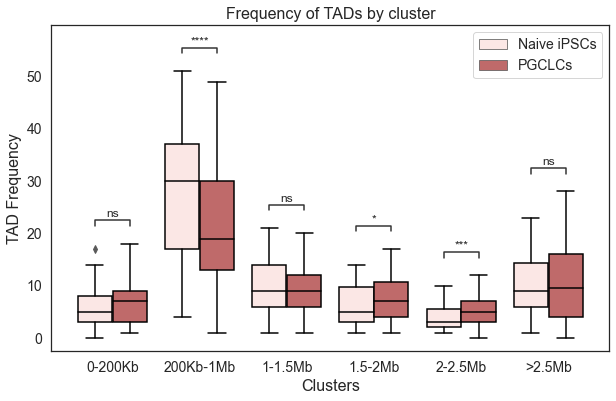

In [20]:
fig = plt.figure(figsize=(10,6))
ax_ = plt.gca()

hue_plot_params = {'data': df_melted, 'x': 'clusters', 'y': 'frequency',
                   'hue': 'sample', 'palette': {'Naive iPSCs': 'mistyrose', 
                                                'PGCLCs': 'indianred'}}

boxprops = {'boxprops': {'edgecolor': 'black'},
            'medianprops': {'color': 'black'},
            'whiskerprops': {'color': 'black'},
            'capprops': {'color': 'black'}}

clust_ = df_melted['clusters'].unique()
pairs = []
for c_ in clust_:
    pairs.append([(c_, "Naive iPSCs"), (c_, "PGCLCs")])

sns.boxplot(ax=ax_, **{**hue_plot_params, **boxprops})

#add annotations
annotator = Annotator(ax_, pairs, **hue_plot_params)
annotator.configure(test="Wilcoxon").apply_and_annotate() #Mann-Whitney

#axis and legend formatting 
ax_.set_xticklabels(interval_names.values())
ax_.set_title('Frequency of TADs by cluster', fontsize=16)
ax_.set_xlabel('Clusters', fontsize=16)
ax_.set_ylabel('TAD Frequency', fontsize=16)
ax_.legend(fontsize=14)
ax_.tick_params(axis='both', which='major', labelsize=14)

# plt.savefig('{}TAD_cluster_freq.png'.format(figure_path), 
#             bbox_inches='tight', dpi=300)
plt.show()